In [102]:
import os
import cv2
import numpy as np
import pandas as pd

In [103]:
# Carpeta base donde estamos trabajando
base_folder = "."

In [104]:
# Obtener las subcarpetas (A, B, C, etc.)
categories = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

# Lista para almacenar datos
data = []
labels = []

In [ ]:
# Dimensiones de las imágenes
height, width = 28, 28

In [106]:
# Leer imágenes de cada categoría
for category in categories:
    folder_path = os.path.join(base_folder, category)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):  # Procesar solo imágenes
            img_path = os.path.join(folder_path, file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
            if image is not None:
                image_flattened = image.flatten()  # Aplanar la imagen (784 valores)
                data.append(image_flattened)
                labels.append(category)

- *Aplanar imagenes:* Para poder aplicar PCA tenemos que aplanar las matrices. La estructura que necesitamos es una matriz cuadrada, donde cada imagen es un vector.
  - Pasamos de tener una imagen que representa una matriz de [28x28] a un vector que representa la información de esa matriz, pero ahora un vector de dimensión [1x784] (28 x 28 = 784).
  - De esta forma, aplanamos nuestras imágenes convirtiéndolas a vectores, y las juntamos para crear nuestra matriz de datos.

In [107]:
# Convertir a matrices numpy
data = np.array(data, dtype="float32")  # Matriz de datos (n_imágenes x 784)
labels = np.array(labels)  # Etiquetas correspondientes

# Imprimir dimensiones
print("Dimensiones de la matriz de datos:", data.shape)  # (n_imágenes, 784)
print("Dimensiones de las etiquetas:", labels.shape)

Dimensiones de la matriz de datos: (27455, 784)
Dimensiones de las etiquetas: (27455,)


- Como vemos, ahora nuestra matriz de datos es de dimensión [27455x784] que contiene 27455 registros (imágenes), los cuales vienen siendo los vectores de nuestras 27455 imágenes, y 784 columnas, que vienen siento los pixeles (variables) aplanados.  

- Nuestra matriz de datos X es muy grande ya que tenemos 784 variables. PCA nos ayudará extraer toda la informacion de esos datos y reducirla a algo mas chico.

## ***Train Test Split***
Realizamos un split de los datos antes de realizar la transformación del PCA
Esta división se realiza para aplicar PCA ÚNICAMENTE AL CONJUNTO DE ENTRENAMIENTO, para evitar Data Leakage
Durante el PCA se calculan las componentes principales en base a las características del Training set, si dieramos al PCA acceso a la información del test set, es decir a las características del test set, no haría sentido ya que podemos generar un sesgo.
Ya que en realidad, el test set, se supone que son datos que no tienes a la mano, entonces no tiene sentido darle al modelo los datos de antemano.

In [108]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train.shape

(21964, 784)

# ***ALGORITMO PCA***

## ***1. Vector de medias muestrales x_bar***

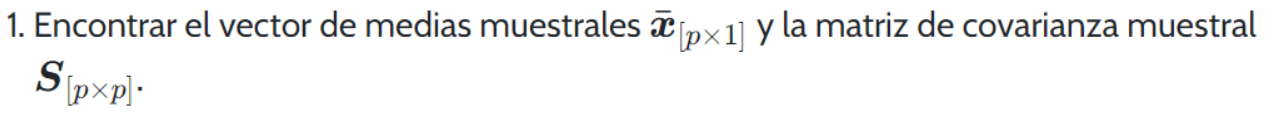

In [109]:
x_bar = X_train.mean(axis=0)
print("Vector de medias (x_bar):", x_bar)
print("Dimensiones de x_bar:", x_bar.shape)  # (784,)

Vector de medias (x_bar): [145.74268  148.38768  151.30031  153.83308  156.29813  158.44077
 160.60472  162.44788  163.95917  165.53123  166.65889  167.85817
 168.45396  169.26051  170.01079  170.42911  170.91919  170.8625
 170.72746  170.54808  170.0011   169.19363  168.10039  166.95343
 165.90758  163.78706  162.09306  161.56123  147.1212   149.8525
 152.79767  155.31757  157.82886  160.05008  162.15836  164.0433
 165.61601  166.89711  168.23279  169.18016  169.45743  170.29012
 170.71886  170.57512  170.62134  171.2582   171.30244  171.277
 171.04753  170.40065  169.78743  168.63254  167.10704  165.20042
 163.6074   162.98756  149.17442  151.93712  154.79895  157.3656
 159.94063  162.16777  164.1859   166.10704  167.4348   168.35922
 169.98607  170.8666   170.39801  170.60576  169.83951  168.84038
 169.02107  169.26817  169.38791  170.02081  170.87065  170.90074
 170.70361  169.81679  168.66832  166.88708  165.46613  164.74135
 151.0106   153.81105  156.61446  159.33446  161.79643  

## ***2. Matriz de covarianza muestral (*S*)***
- Encontramos la matriz de covarianza muestral ***S***.
- Para hacer PCA primero encontramos nuestra matriz de covarianza, la cual tenemos que estimar porque es desconocida.

In [110]:
# Matriz de covarianza muestral
Sigma = np.cov(X_train.T)  # Transponemos para que las columnas sean las variables
print("Dimensiones de la matriz de covarianza (Sigma):", Sigma.shape)  # (784, 784)

Dimensiones de la matriz de covarianza (Sigma): (784, 784)


## ***3. Eigenvalores y eigenvectores***

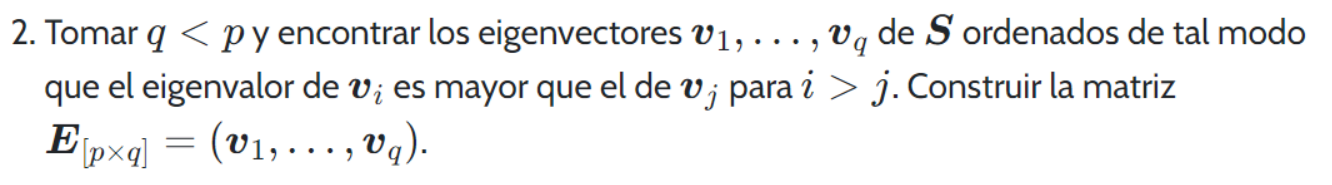

- Teniendo la matriz de covarianza muestral ***S***, aplicamos lo siguiente:
  - De ***S*** necesitamos calcular todas los componetes principales (Z1, Z2, ..., Zn),  y para cada una de los componentes, necesitamos encontrar sus vectores de loading correspondientes (**a1**, **a2**, ..., **a3**).
  - Los loadings son desconocidos, sin embargo, por resultados anteriores sabemos que son los eigenvectores de ***S***.
  - Sabemos que la primer componente principal debe explicar la mayor cantidad de varianza posible en los datos, la segunda componente explica la mayor cantidad de varianza restante y asi sucesivamente, de forma que va decreciendo la varianza de cada componente. Por resultados anteriores, sabemos que la varianza de los componentes corresponden a los eigenvalores de ***S***, ordenados de mayor a menor (lambda1 > lambda2 ... > lambdap).
  - De esta forma, asignamos los vectores de loadings de cada componente pricipal segun su eigenvalor asociado; i.e el eigenvalor más grande sería la varianza de la primer componente principal *Var(Z1) = lambda1*, y el eigenvector asociado a *lambda1*, sería el vector de loadings de la primer componente ***a1 = v1***.

In [111]:
# Eigenvalores y eigenvectores
Lambda, Q = np.linalg.eig(Sigma)
print("Eigenvalores (Lambda):", Lambda)
print("Dimensiones de Lambda:", Lambda.shape)  # (784,)
print("Matriz de eigenvectores (Q):", Q)
print("Dimensiones de Q:", Q.shape)  # (784, 784)


Eigenvalores (Lambda): [5.34000663e+05 1.63198428e+05 1.31799637e+05 8.75424939e+04
 5.56852492e+04 5.34449578e+04 4.63918585e+04 4.03577700e+04
 3.76375177e+04 2.95517883e+04 2.83670906e+04 2.49892361e+04
 2.14879166e+04 2.04514033e+04 1.73426543e+04 1.50679586e+04
 1.33102900e+04 1.28164753e+04 1.15760524e+04 1.07272991e+04
 9.85595706e+03 9.19720078e+03 8.33036928e+03 8.03226177e+03
 7.85981170e+03 7.27626948e+03 6.68613636e+03 6.30254346e+03
 6.13626239e+03 5.87845876e+03 5.71987241e+03 5.60795501e+03
 5.39967643e+03 5.19342831e+03 5.04603238e+03 4.74398415e+03
 4.69999422e+03 4.53752453e+03 4.45215683e+03 4.26297697e+03
 4.11423113e+03 4.01006907e+03 3.91934753e+03 3.82305088e+03
 3.62820383e+03 3.49146894e+03 3.45964728e+03 3.28599160e+03
 3.27786375e+03 3.19468212e+03 3.07042314e+03 2.95084934e+03
 3.00105523e+03 2.85807936e+03 2.79520950e+03 2.73367135e+03
 2.61090816e+03 2.57590413e+03 2.51251167e+03 2.43246193e+03
 2.40620540e+03 2.34478525e+03 2.28218579e+03 2.22872472e+03
 

### ***3.1 Ordenamos eigenvalores y eigenvectores***

In [112]:
idx = Lambda.argsort()[::-1]  # Índices para ordenar de mayor a menor
Lambda = Lambda[idx]
Q = Q[:, idx]
print("Eigenvalores ordenados:", Lambda)
print("Matriz de eigenvectores ordenada (Q):", Q)

Eigenvalores ordenados: [5.34000663e+05 1.63198428e+05 1.31799637e+05 8.75424939e+04
 5.56852492e+04 5.34449578e+04 4.63918585e+04 4.03577700e+04
 3.76375177e+04 2.95517883e+04 2.83670906e+04 2.49892361e+04
 2.14879166e+04 2.04514033e+04 1.73426543e+04 1.50679586e+04
 1.33102900e+04 1.28164753e+04 1.15760524e+04 1.07272991e+04
 9.85595706e+03 9.19720078e+03 8.33036928e+03 8.03226177e+03
 7.85981170e+03 7.27626948e+03 6.68613636e+03 6.30254346e+03
 6.13626239e+03 5.87845876e+03 5.71987241e+03 5.60795501e+03
 5.39967643e+03 5.19342831e+03 5.04603238e+03 4.74398415e+03
 4.69999422e+03 4.53752453e+03 4.45215683e+03 4.26297697e+03
 4.11423113e+03 4.01006907e+03 3.91934753e+03 3.82305088e+03
 3.62820383e+03 3.49146894e+03 3.45964728e+03 3.28599160e+03
 3.27786375e+03 3.19468212e+03 3.07042314e+03 3.00105523e+03
 2.95084934e+03 2.85807936e+03 2.79520950e+03 2.73367135e+03
 2.61090816e+03 2.57590413e+03 2.51251167e+03 2.43246193e+03
 2.40620540e+03 2.34478525e+03 2.28218579e+03 2.22872472e+03


## ***4. Seleccionar componentes principales***

**Cuantas componentes seleccionamos?**

- Una regla de dedo dice que seleccionemos componentes que en conjunto expliquen entre el 70% y 90% de la variabilidad total.

- Seleccionamos tantas componentes de modo que expliquemos al menos el 80% de variabilidad.

- *Como hacemos esto?*
 - Usamos la proporcion varianza explicada:

 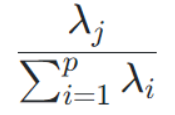

In [113]:
# Proporción acumulada de varianza explicada
var_acum = (Lambda / Lambda.sum()).cumsum()
print("Varianza explicada acumulada:", var_acum)

# Encontrar el número de componentes que explican al menos el 80%
n_components = np.argmax(var_acum >= 0.80) + 1
print(f"Componentes seleccionados: {n_components} (explican al menos el 80% de la varianza)")


Varianza explicada acumulada: [0.31205202 0.4074197  0.48443897 0.53559586 0.56813644 0.59936788
 0.62647772 0.65006144 0.67205554 0.68932462 0.70590139 0.72050426
 0.73306107 0.74501219 0.75514665 0.76395186 0.77172994 0.77921946
 0.78598412 0.79225279 0.79801228 0.80338681 0.8082548  0.81294858
 0.81754159 0.8217936  0.82570075 0.82938375 0.83296957 0.83640475
 0.83974725 0.84302435 0.84617974 0.8492146  0.85216333 0.85493556
 0.85768208 0.86033365 0.86293534 0.86542649 0.8678307  0.87017405
 0.87246439 0.87469845 0.87681865 0.87885895 0.88088065 0.88280087
 0.88471634 0.88658321 0.88837746 0.89013118 0.89185555 0.89352572
 0.89515915 0.89675661 0.89828234 0.89978761 0.90125584 0.90267729
 0.90408339 0.90545361 0.90678724 0.90808963 0.90936962 0.91059772
 0.91180994 0.91300562 0.91418163 0.91534617 0.91648268 0.91758321
 0.91865953 0.9197315  0.92077728 0.92181825 0.92284666 0.92385031
 0.9248454  0.9258089  0.9267463  0.9276747  0.92856678 0.92944565
 0.93031448 0.93117389 0.9320239

- A partir de la componente numero 22 ya se explica el 80% de la variabilidad, asi que tomamos las primeras 22 componentes, que en conjunto explican alrededor del 80%.

- Al seleccionar 22 componentes, significa que pasamos de tener 784 columnas a unicamente 22.

In [114]:
# Proyección de los datos a las componentes principales seleccionadas
Q_reducido = Q[:, :n_components]  # Seleccionar los primeros n_components eigenvectores
X_train_pca = np.dot(X_train - x_bar, Q_reducido)  # Transformar los datos de entrenaimiento
X_test_pca = np.dot(X_test - x_bar, Q_reducido)  # Transformar los datos de prueba
print("Dimensiones de los datos transformados (PCA):", X_train_pca.shape)  # (n_imágenes, n_components)
print("Dimensiones de los datos de prueba transformados (PCA):", X_test_pca.shape)

Dimensiones de los datos transformados (PCA): (21964, 22)
Dimensiones de los datos de prueba transformados (PCA): (5491, 22)


### ***4.1 Scree plot para verificar el numero de componentes***

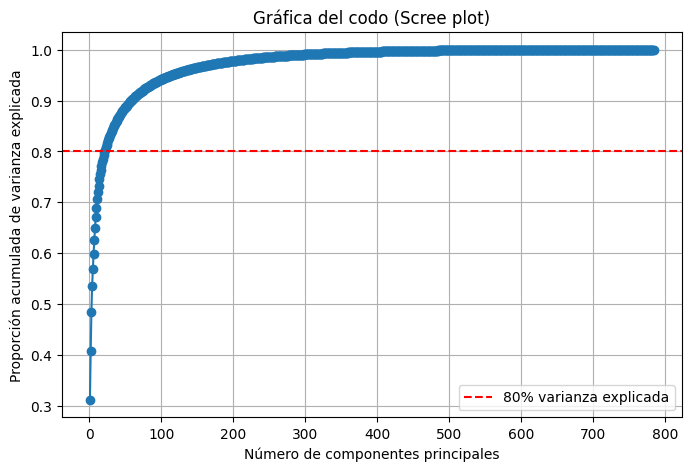

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(Lambda) + 1), (Lambda / Lambda.sum()).cumsum(), marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% varianza explicada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Proporción acumulada de varianza explicada')
plt.title('Gráfica del codo (Scree plot)')
plt.legend()
plt.grid()
plt.show()

# ***AQUÍ YA TERMINAMOS PCA***

## ***Esto de los eigenvectores es puro yap (lo podriamos quitar)***

### ***Eigenvectores***
Toda la información que contienen nuestras imágenes está contenida en estos eigenvectores

Dimensiones de E (matriz de eigenvectores seleccionados): (784, 22)


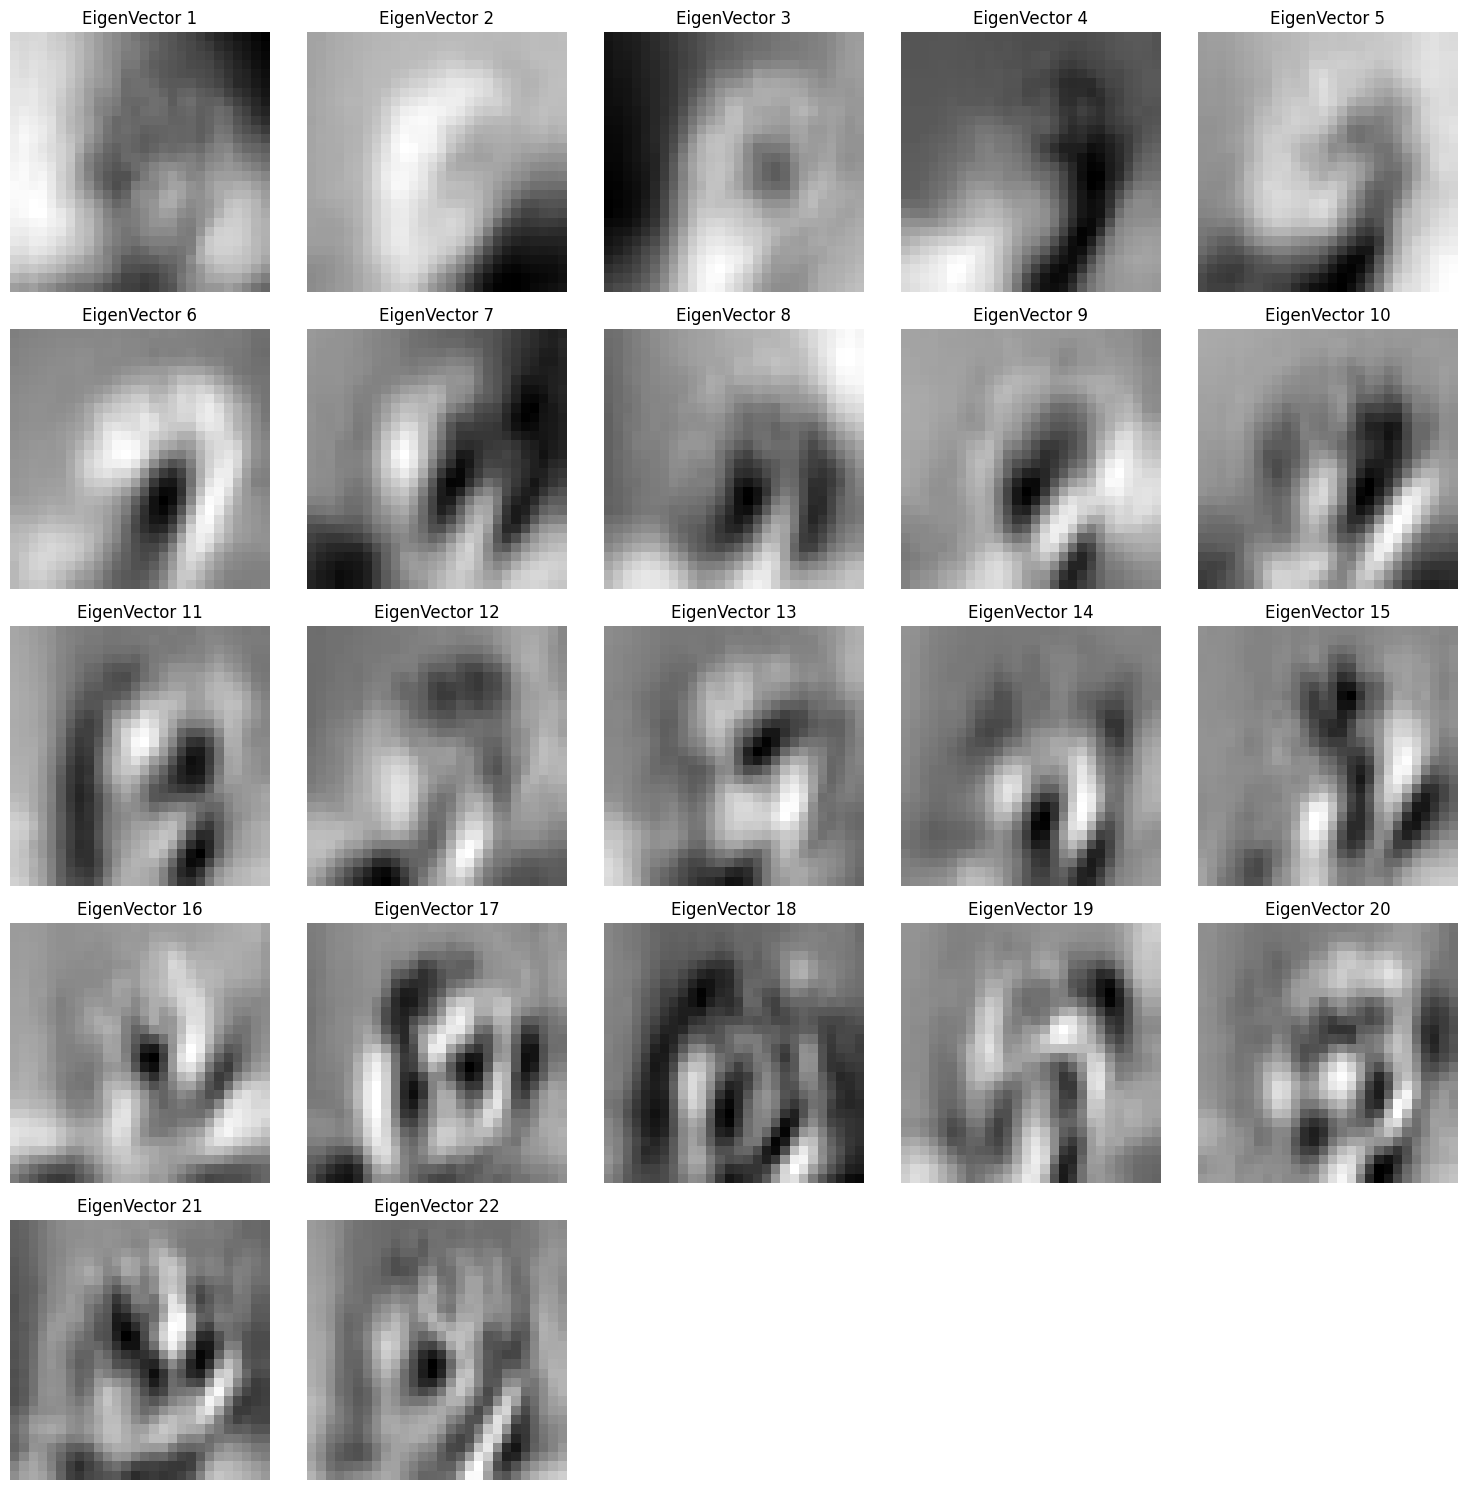

In [116]:
import matplotlib.pyplot as plt
import numpy as np

q = 22  # Número de componentes seleccionadas
E = Q[:, :q]  # Matriz de eigenvectores seleccionados
print("Dimensiones de E (matriz de eigenvectores seleccionados):", E.shape)  # (784, 22)

# Calcular filas y columnas para la cuadrícula
n_cols = 5  # Número de columnas
n_rows = (q + n_cols - 1) // n_cols  # Número de filas, para asegurar que todas las imágenes se muestren

# Graficar los primeros eigenvectores como imágenes
plt.figure(figsize=(15, 15))  # Ajustar el tamaño de la figura

for i in range(q):
    eigenimage = E[:, i].reshape(28, 28)  # Redimensionar para mostrar como imagen
    plt.subplot(n_rows, n_cols, i + 1)  # Distribuir en la cuadrícula
    plt.title(f"EigenVector {i + 1}")
    plt.imshow(eigenimage, cmap="gray")
    plt.axis("off")

plt.tight_layout()  # Asegurar que los subgráficos no se empalmen
plt.show()


# ***Entrenar Clasificadores de imágenes***

## Entrenar un clasificador KNN con PCA

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=5)  # Usamos 5 vecinos como ejemplo
knn.fit(X_train_pca, y_train)  # Etiquetas solo para el conjunto de entrenamiento

# Realizar predicciones en el conjunto de prueba
predictions = knn.predict(X_test_pca)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador KNN:", accuracy)

Exactitud del clasificador KNN: 0.9717719905299581


## Entrenar un clasificador KNN sin PCA

In [118]:
knn = KNeighborsClassifier(n_neighbors=5)  # Usamos 5 vecinos como ejemplo
knn.fit(X_train, y_train)  # Etiquetas solo para el conjunto de entrenamiento

# Realizar predicciones en el conjunto de prueba
predictions = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador KNN:", accuracy)

Exactitud del clasificador KNN: 0.9947186304862502


## Entrenar un Clasificador Random Forest con PCA

In [126]:
# Entrenar un clasificador Random Forest con los datos transformados
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)  # Entrenar con los datos transformados

# Realizar predicciones en el conjunto de prueba
predictions = rf.predict(X_test_pca)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador Random Forest:", accuracy)

Exactitud del clasificador Random Forest: 1.0


## Entrenar un clasificador Random Forest sin PCA

In [120]:
## Entrenar un clasificador Random Forest con los datos originales

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Entrenar con los datos transformados

# Realizar predicciones en el conjunto de prueba
predictions = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador Random Forest:", accuracy)

Exactitud del clasificador Random Forest: 0.9943543981059916
